# Analisis Sentimen Review Instagram di Play Store Menggunakan Metode Naive Bayes dan Metode Support Vector Machine

In [1]:
import pandas as pd
import zipfile, os, glob
import re
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

**Preprocessing Data**

In [2]:
df = pd.read_csv('instagram.csv')
df.head()

,review_description,rating,review_date
0,"The app is good for connecting with friends, f...",3,2023-07-11 23:57:07
1,"Used to be my favorite social media app, but ""...",2,2023-07-22 21:37:09
2,Instagram is the best of all the social media....,5,2023-07-25 03:24:58
3,"I love this app.. but as of late, I have been ...",2,2023-07-09 04:49:57
4,Used to be a great app but there are so many m...,3,2023-07-17 16:47:04


In [3]:
df_sampled = df.sample(n=10000, random_state=42)
print(f"Sampled Data Shape: {df_sampled.shape}")

Sampled Data Shape: (10000, 3)


*Rating*

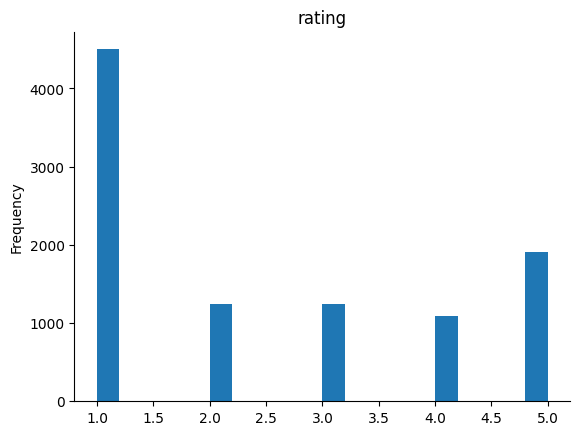

In [4]:
df_sampled['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
df_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 132418 to 151502
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_description  10000 non-null  object
 1   rating              10000 non-null  int64 
 2   review_date         10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


In [6]:
df_sampled.shape

(10000, 3)

In [7]:
df_sampled.describe()

,rating
count,10000.000000
mean,2.466800
std,1.586174
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,5.000000


In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Hanifah Az-
[nltk_data]     Zahra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

*Pembersihan teks*

In [10]:
def clean_text(text):
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Menghapus karakter khusus
    text = re.sub(r'\s+', ' ', text).strip()  # Menghapus spasi berlebih
    return text

df_sampled['cleaned_review'] = df_sampled['review_description'].apply(clean_text)

# Menampilkan hasil pembersihan teks
print(df_sampled[['review_description', 'cleaned_review']].head())

                                       review_description  \
132418  the blue color in the direct causes headache, ...   
154949  I am using this app from 2k16 . Ok now it's mo...   
204116  My account has been experiencing lags and stor...   
28403   My Instagram isn't showing any story option nt...   
31508   If you increase the time of story into 60 seco...   

                                           cleaned_review  
132418  the blue color in the direct causes headache I...  
154949  I am using this app from k Ok now its modern d...  
204116  My account has been experiencing lags and stor...  
28403   My Instagram isnt showing any story option nto...  
31508   If you increase the time of story into seconds...  


In [11]:
print('Review awal\t:',df_sampled['review_description'].iloc[12])
print('Hasil Pembersihan\t:',df_sampled['cleaned_review'].iloc[12])

Review awal	: The highlights section is full of glitch. If I add some stories from archive, it automatically removes that within seconds. Also, the quality of the photo/video does not remain the same while uploading story.
Hasil Pembersihan	: The highlights section is full of glitch If I add some stories from archive it automatically removes that within seconds Also the quality of the photovideo does not remain the same while uploading story


In [12]:
df_sampled.isna().sum()

review_description    0
rating                0
review_date           0
cleaned_review        0
dtype: int64

In [13]:
print(df_sampled.cleaned_review)

132418    the blue color in the direct causes headache I...
154949    I am using this app from k Ok now its modern d...
204116    My account has been experiencing lags and stor...
28403     My Instagram isnt showing any story option nto...
31508     If you increase the time of story into seconds...
                                ...                        
152840    Cant open the applicationthe screen blacked ou...
184471    It isnt a terrible app Wish the website worked...
36143     Super but i dont know any tricks of Instagram ...
196287    Instagram at its worse Doesnt give the feature...
151502    used to be good now it freezes up on start up ...
Name: cleaned_review, Length: 10000, dtype: object


*Tokenization*

In [14]:
def tokenize_text(text):
    return word_tokenize(text)

df_sampled['tokenized_review'] = df_sampled['cleaned_review'].apply(tokenize_text)

# Menampilkan hasil tokenisasi
print(df_sampled[['cleaned_review', 'tokenized_review']].head())

                                           cleaned_review  \
132418  the blue color in the direct causes headache I...   
154949  I am using this app from k Ok now its modern d...   
204116  My account has been experiencing lags and stor...   
28403   My Instagram isnt showing any story option nto...   
31508   If you increase the time of story into seconds...   

                                         tokenized_review  
132418  [the, blue, color, in, the, direct, causes, he...  
154949  [I, am, using, this, app, from, k, Ok, now, it...  
204116  [My, account, has, been, experiencing, lags, a...  
28403   [My, Instagram, isnt, showing, any, story, opt...  
31508   [If, you, increase, the, time, of, story, into...  


*Stopword Removal*

In [15]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

df_sampled['stopwords_removed'] = df_sampled['tokenized_review'].apply(remove_stopwords)

# Menampilkan hasil stopword removal
print(df_sampled[['tokenized_review', 'stopwords_removed']].head())

                                         tokenized_review  \
132418  [the, blue, color, in, the, direct, causes, he...   
154949  [I, am, using, this, app, from, k, Ok, now, it...   
204116  [My, account, has, been, experiencing, lags, a...   
28403   [My, Instagram, isnt, showing, any, story, opt...   
31508   [If, you, increase, the, time, of, story, into...   

                                        stopwords_removed  
132418  [blue, color, direct, causes, headache, good, ...  
154949  [using, app, k, Ok, modern, days, tick, tok, a...  
204116  [account, experiencing, lags, story, problems,...  
28403   [Instagram, isnt, showing, story, option, nto,...  
31508       [increase, time, story, seconds, comfortable]  


*Stemming*

In [16]:
ps = PorterStemmer()

def stem_words(tokens):
    return [ps.stem(word) for word in tokens]

df_sampled['stemmed_review'] = df_sampled['stopwords_removed'].apply(stem_words)

# Menampilkan hasil stemming
print(df_sampled[['stopwords_removed', 'stemmed_review']].head())

                                        stopwords_removed  \
132418  [blue, color, direct, causes, headache, good, ...   
154949  [using, app, k, Ok, modern, days, tick, tok, a...   
204116  [account, experiencing, lags, story, problems,...   
28403   [Instagram, isnt, showing, story, option, nto,...   
31508       [increase, time, story, seconds, comfortable]   

                                           stemmed_review  
132418  [blue, color, direct, caus, headach, good, ide...  
154949  [use, app, k, ok, modern, day, tick, tok, amaz...  
204116  [account, experienc, lag, stori, problem, repo...  
28403   [instagram, isnt, show, stori, option, nto, po...  
31508             [increas, time, stori, second, comfort]  


*Mengkategorikan review Positif, Negatif, dan Netral*

In [17]:
def categorize_rating(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df_sampled['rating_category'] = df_sampled['rating'].apply(categorize_rating)

# Menampilkan hasil kategori rating
print(df_sampled[['rating', 'rating_category']].head())

        rating rating_category
132418       1        negative
154949       5        positive
204116       1        negative
28403        5        positive
31508        5        positive


In [18]:
df_sampled['rating_category'] = df_sampled['rating'].apply(categorize_rating)
print("Rating Categorization Done")

# Menampilkan hasil preprocessing secara berdampingan
df_display = df_sampled[['review_description', 'cleaned_review', 'tokenized_review', 'stopwords_removed', 'stemmed_review']]

# Menampilkan beberapa baris pertama
print(df_display.head())

# Jika diperlukan untuk menyimpan hasil ke file CSV
df_display.to_csv('preprocessed_reviews.csv', index=False)

Rating Categorization Done
                                       review_description  \
132418  the blue color in the direct causes headache, ...   
154949  I am using this app from 2k16 . Ok now it's mo...   
204116  My account has been experiencing lags and stor...   
28403   My Instagram isn't showing any story option nt...   
31508   If you increase the time of story into 60 seco...   

                                           cleaned_review  \
132418  the blue color in the direct causes headache I...   
154949  I am using this app from k Ok now its modern d...   
204116  My account has been experiencing lags and stor...   
28403   My Instagram isnt showing any story option nto...   
31508   If you increase the time of story into seconds...   

                                         tokenized_review  \
132418  [the, blue, color, in, the, direct, causes, he...   
154949  [I, am, using, this, app, from, k, Ok, now, it...   
204116  [My, account, has, been, experiencing, lags, a..

In [19]:
# Menggabungkan kata-kata yang telah di-stemming menjadi satu kalimat kembali
df_sampled['final_review'] = df_sampled['stemmed_review'].apply(lambda x: ' '.join(x))

# Menggunakan TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X = tfidf_vectorizer.fit_transform(df_sampled['final_review']).toarray()

# Menampilkan bentuk dari vektor TF-IDF
print(X.shape)

(10000, 2000)


*Text Blob*

In [20]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

df_sampled['polarity'] = df_sampled['review_description'].apply(lambda x: get_sentiment(x)[0])
df_sampled['subjectivity'] = df_sampled['review_description'].apply(lambda x: get_sentiment(x)[1])

In [21]:
def classify_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

df_sampled['sentiment'] = df_sampled['polarity'].apply(classify_sentiment)

In [22]:
print(df_sampled.head())

                                       review_description  rating  \
132418  the blue color in the direct causes headache, ...       1   
154949  I am using this app from 2k16 . Ok now it's mo...       5   
204116  My account has been experiencing lags and stor...       1   
28403   My Instagram isn't showing any story option nt...       5   
31508   If you increase the time of story into 60 seco...       5   

                review_date  \
132418  2019-12-19 20:28:48   
154949  2021-10-22 16:26:28   
204116  2021-05-20 04:52:33   
28403   2023-07-22 06:15:37   
31508   2023-06-15 16:59:58   

                                           cleaned_review  \
132418  the blue color in the direct causes headache I...   
154949  I am using this app from k Ok now its modern d...   
204116  My account has been experiencing lags and stor...   
28403   My Instagram isnt showing any story option nto...   
31508   If you increase the time of story into seconds...   

                               

In [23]:
df_sampled.to_csv('processed_instagram_reviews.csv', index=False)

In [24]:
x = df_sampled.drop(columns = ['rating', 'polarity', 'subjectivity', 'review_description','review_date' ])
y = df_sampled['rating']
print (x)

                                           cleaned_review  \
132418  the blue color in the direct causes headache I...   
154949  I am using this app from k Ok now its modern d...   
204116  My account has been experiencing lags and stor...   
28403   My Instagram isnt showing any story option nto...   
31508   If you increase the time of story into seconds...   
...                                                   ...   
152840  Cant open the applicationthe screen blacked ou...   
184471  It isnt a terrible app Wish the website worked...   
36143   Super but i dont know any tricks of Instagram ...   
196287  Instagram at its worse Doesnt give the feature...   
151502  used to be good now it freezes up on start up ...   

                                         tokenized_review  \
132418  [the, blue, color, in, the, direct, causes, he...   
154949  [I, am, using, this, app, from, k, Ok, now, it...   
204116  [My, account, has, been, experiencing, lags, a...   
28403   [My, Instagram,

In [25]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df_sampled['review_description'])
y = df_sampled['sentiment']

In [26]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=123)

In [27]:
y = df_sampled['rating_category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Model dan Evaluasi**

*Naive Bayes*

In [28]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred, zero_division=1)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")

Accuracy: 0.7235
Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.95      0.81      1139
     neutral       1.00      0.00      0.00       252
    positive       0.80      0.60      0.68       609

    accuracy                           0.72      2000
   macro avg       0.83      0.52      0.50      2000
weighted avg       0.77      0.72      0.67      2000

Confusion Matrix:
 [[1083    0   56]
 [ 217    0   35]
 [ 245    0  364]]


*Support Vector Machine*

In [29]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, svm_pred)}")
print(f"Classification Report:\n {classification_report(y_test, svm_pred, zero_division=1)}")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, svm_pred)}")

Accuracy: 0.7565
Classification Report:
               precision    recall  f1-score   support

    negative       0.74      0.96      0.83      1139
     neutral       0.00      0.00      1.00       252
    positive       0.82      0.68      0.75       609

    accuracy                           0.76      2000
   macro avg       0.52      0.55      0.86      2000
weighted avg       0.67      0.76      0.83      2000

Confusion Matrix:
 [[1096    0   43]
 [ 203    0   49]
 [ 191    1  417]]


**Visualisasi**

*Melihat tren perubahan dari rata-rata rating terhadap waktu*

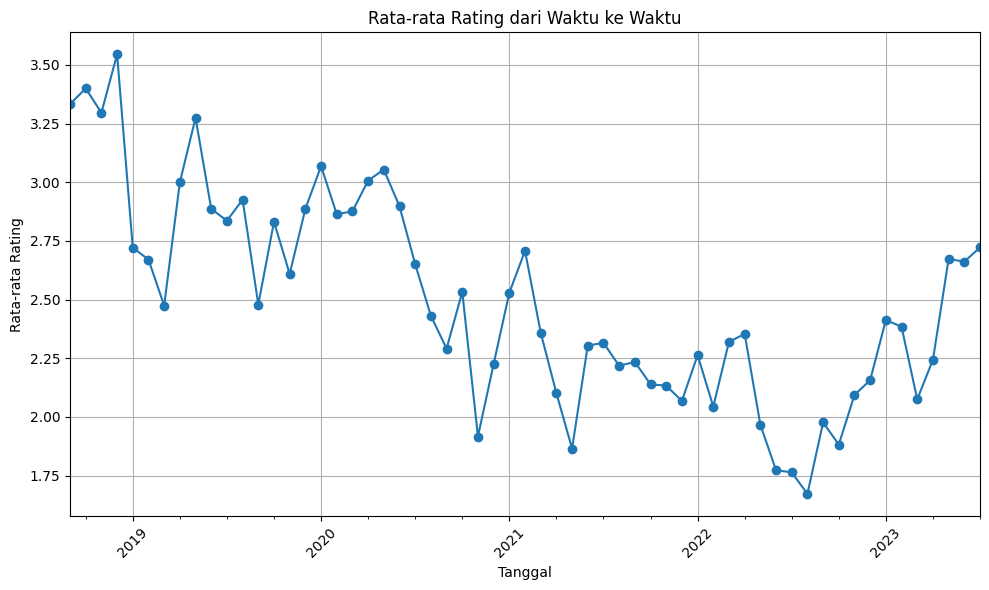

In [30]:
# Mengelompokkan data berdasarkan tanggal
df_sampled['review_date'] = pd.to_datetime(df_sampled['review_date'])
df_time = df_sampled.groupby(df_sampled['review_date'].dt.to_period('M'))['rating'].mean()

# Plotting line chart
plt.figure(figsize=(10, 6))
df_time.plot(kind='line', marker='o')
plt.title('Rata-rata Rating dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Rata-rata Rating')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Melihat distribusi kategori rating (positif, netral, dan negatif)*

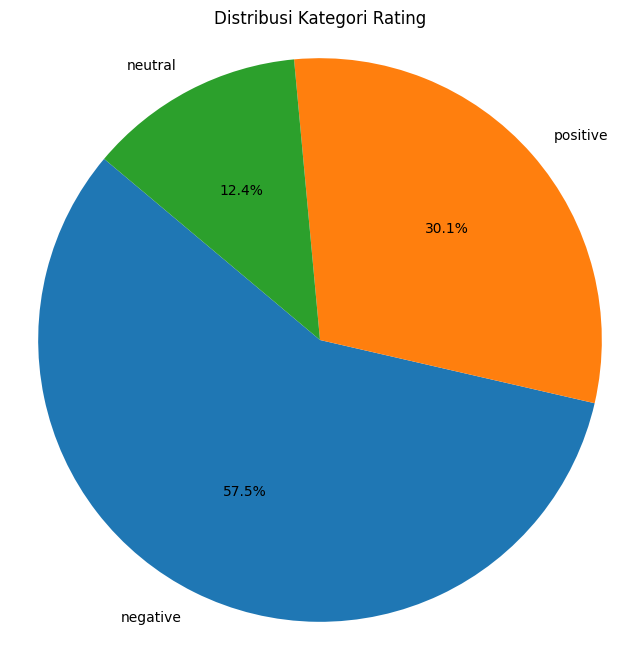

In [31]:
# Hitung jumlah review untuk setiap kategori rating
rating_counts = df_sampled['rating_category'].value_counts()

# Plot Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Kategori Rating')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

*Melihat jumlah review untuk setiap kategori sentimen*

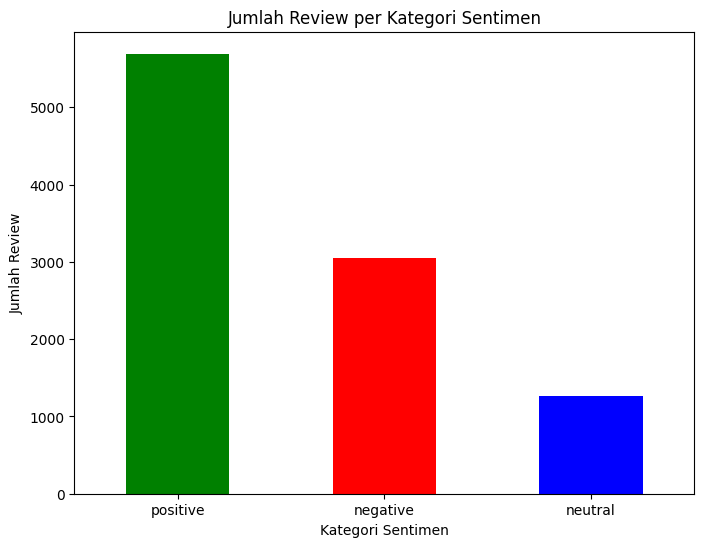

In [32]:
# Menghitung jumlah review untuk setiap kategori sentimen
sentiment_counts = df_sampled['sentiment'].value_counts()

# Membuat bar chart
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Jumlah Review per Kategori Sentimen')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah Review')
plt.xticks(rotation=0)
plt.show()

*Melihat jumlah review untuk setiap rating*

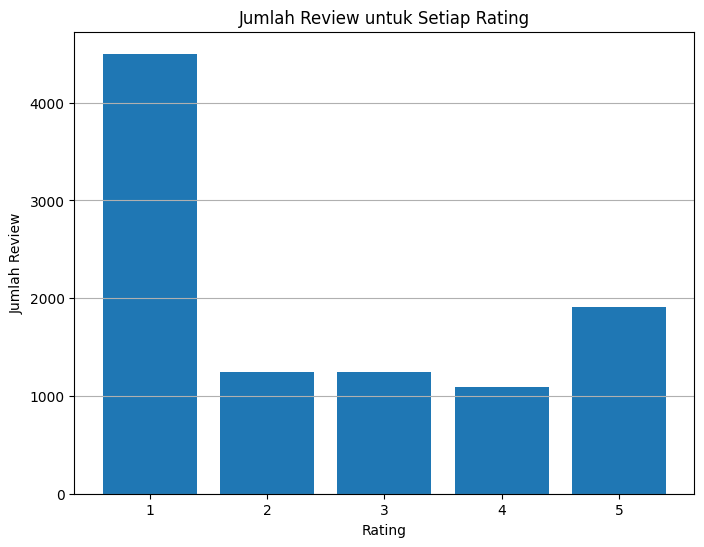

In [33]:
# Melihat jumlah review untuk setiap rating
rating_counts = df_sampled['rating'].value_counts().sort_index()

# Membuat bar chart
plt.figure(figsize=(8, 6))
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.title('Jumlah Review untuk Setiap Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah Review')
plt.grid(axis='y')
plt.show()

*Melihat hubungan antara polarity dan subjectivity dari review*

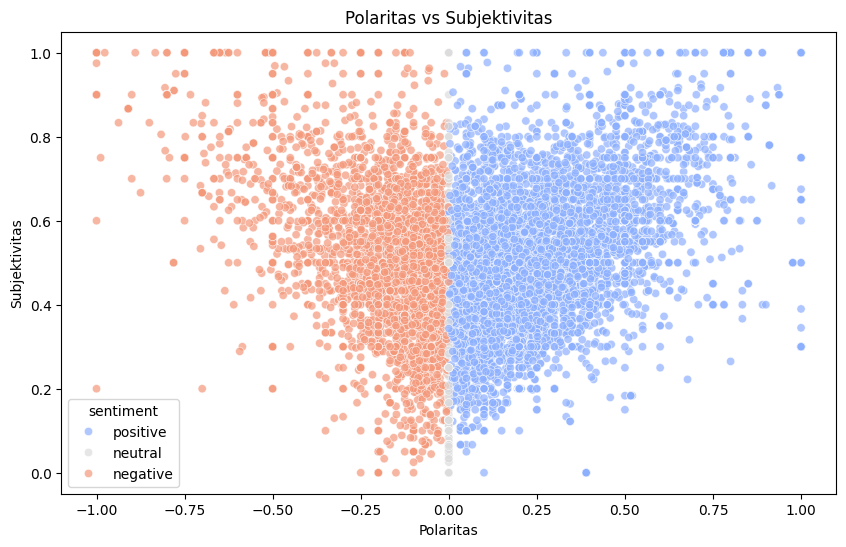

In [34]:
# Membuat scatter plot untuk melihat hubungan antara polarity dan subjectivity dari review
plt.figure(figsize=(10,6))
sns.scatterplot(x='polarity', y='subjectivity', data=df_sampled, hue='sentiment', palette='coolwarm', alpha=0.7)
plt.title('Polaritas vs Subjektivitas')
plt.xlabel('Polaritas')
plt.ylabel('Subjektivitas')
plt.show()

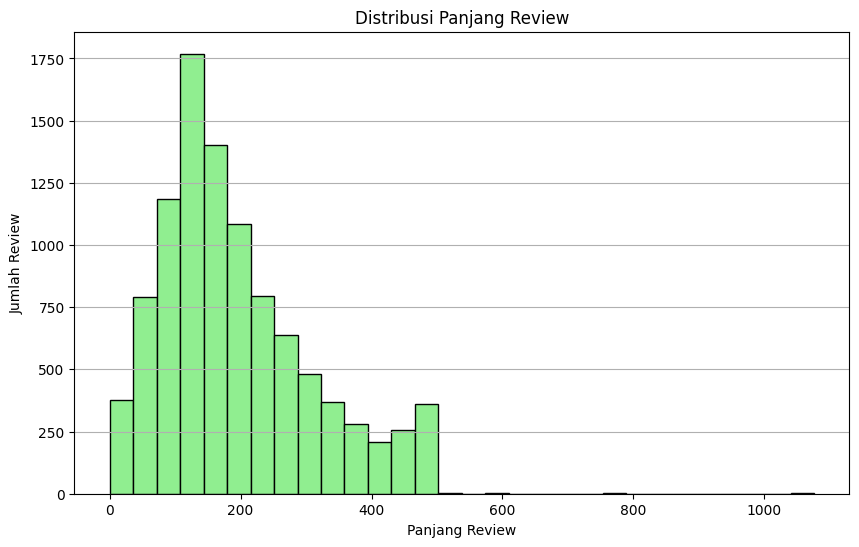

In [35]:
# Hitung panjang review
df_sampled['review_length'] = df_sampled['cleaned_review'].apply(len)

# Plot Histogram
plt.figure(figsize=(10, 6))
plt.hist(df_sampled['review_length'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribusi Panjang Review')
plt.xlabel('Panjang Review')
plt.ylabel('Jumlah Review')
plt.grid(axis='y')
plt.show()